In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from optimization import *
import time

In [2]:

def generate_madx_fodo_lattice(num_cells, filename, outputfile, strengths, magnet_lengths, initbetx, initbetay):
    fodo_template = """
TITLE, '{title}';

! Define sequence
FODO_SEQ: sequence, l=16;
    {elements}
endsequence;

! Define beam
BEAM, particle=POSMUON;

! Use sequence
USE, sequence=FODO_SEQ;

! Perform twiss
twiss, file={outfile}, BETX={initbetaxx}, BETY={initbetayy};

STOP;
"""

    length_per_lattice = 16/num_cells
    midway = length_per_lattice / 2
    magnet_center = magnet_lengths / 2

    elements = []
    for i in range(num_cells):
        first_magnet = i * length_per_lattice + magnet_center
        second_magnet = i * length_per_lattice + magnet_center + midway
        elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
        elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")

 
    elements_str = "\n    ".join(elements)

    madx_script = fodo_template.format(title=filename, elements=elements_str, outfile=outputfile, strength=strengths, initbetaxx=initbetx, initbetayy=initbetay)

    with open(filename, "w") as file:
        file.write(madx_script)
    
    print(f"MAD-X script generated and saved as {filename}")

# Specify the number of FODO cells


In [3]:
def generate_madx_fodo_lmdif(num_cells, filename, outputfile, strengths, magnet_lengths, initbetx, initbetay, constraints):
    fodo_template = """
TITLE, '{title}';

! Define sequence
FODO_SEQ: sequence, l=16;
    {elements}
endsequence;

! Define beam
BEAM, particle=POSMUON;

! Use sequence
USE, sequence=FODO_SEQ;

MATCH, sequence=FODO_SEQ,
    BETX={initbetaxx}, BETY={initbetayy};
    {elements_to_vary}
ENDMATCH;

twiss, file={outfile}, BETX={initbetaxx}, BETY={initbetayy};

STOP;
"""

    length_per_lattice = 16/num_cells
    defocusing = length_per_lattice / 2
    length = (defocusing - magnet_lengths)
    print(f"for length we are getting {length}")
    center = length / 2 
    magnet_center = magnet_lengths / 2

    elements = []
    for i in range(num_cells):
        first_magnet = i * length_per_lattice + magnet_center
        second_magnet = i * length_per_lattice + magnet_center + defocusing
        elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
        elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")
 
    elements_str = "\n    ".join(elements)

    for_varying = []
    for i in range(num_cells):
        for_varying.append(f"vary, name=QF{i + 1}->K1, step=.00001;")
        for_varying.append(f"vary, name=QD{i + 1}->K1, step=0.00001;")


    for_varying.append(f"constraint, sequence=FODO_SEQ, range=#s/#e, BETX={constraints[0]}, BETY={constraints[1]};")
    for_varying.append(f"constraint, sequence=FODO_SEQ, range=QD{num_cells}, BETX={constraints[2]}, BETY={constraints[3]};")

    for_varying.append("LMDIF, calls=200000, tolerance=1E-10;")


    varying_str = "\n    ".join(for_varying)




    madx_script = fodo_template.format(title=filename, elements=elements_str, outfile=outputfile,
                                       strength=strengths, initbetaxx=initbetx, initbetayy=initbetay, elements_to_vary=varying_str)

    with open(filename, "w") as file:
        file.write(madx_script)
    
    print(f"MAD-X script generated and saved as {filename}")

# Specify the number of FODO cells


In [4]:
def generate_madx_fodo_jacobian(num_cells, filename, outputfile, strengths, magnet_lengths, initbetx, initbetay, constraints):
    fodo_template = """
TITLE, '{title}';

! Define sequence
FODO_SEQ: sequence, l=16;
    {elements}
    MKR: Marker, at=16;
endsequence;

! Define beam
BEAM, particle=POSMUON;

! Use sequence
USE, sequence=FODO_SEQ;

MATCH, sequence=FODO_SEQ,
    BETX={initbetaxx}, BETY={initbetayy};
    {elements_to_vary}
ENDMATCH;

twiss, file={outfile}, BETX={initbetaxx}, BETY={initbetayy};

STOP;
"""

    length_per_lattice = 16/num_cells
    defocusing = length_per_lattice / 2
    length = (defocusing - magnet_lengths)
    print(f"for length we are getting {length}")
    center = length / 2 
    magnet_center = magnet_lengths / 2

    elements = []
    for i in range(num_cells):
        first_magnet = i * length_per_lattice + magnet_center
        second_magnet = i * length_per_lattice + magnet_center + defocusing
        elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
        elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")
 
    elements_str = "\n    ".join(elements)

    for_varying = []
    for i in range(num_cells):
        for_varying.append(f"vary, name=QF{i + 1}->K1, step=.00001;")
        for_varying.append(f"vary, name=QD{i + 1}->K1, step=0.00001;")


    for_varying.append(f"constraint, sequence=FODO_SEQ, range=#s/#e, BETX<{constraints[0]}, BETY<{constraints[1]};")
    for_varying.append(f"constraint, sequence=FODO_SEQ, range=mkr, BETX={constraints[2]}, BETY={constraints[3]};")

    for_varying.append("JACOBIAN, calls=200000, tolerance=1E-10;")


    varying_str = "\n    ".join(for_varying)




    madx_script = fodo_template.format(title=filename, elements=elements_str, outfile=outputfile,
                                       strength=strengths, initbetaxx=initbetx, initbetayy=initbetay, elements_to_vary=varying_str)

    with open(filename, "w") as file:
        file.write(madx_script)
    
    print(f"MAD-X script generated and saved as {filename}")

# Specify the number of FODO cells


In [5]:
def generate_madx_fodo_jacobian_optimization(num_cells, filename, outputfile, strengths, magnet_lengths, initbetx, initbetay,
                                    BETX, BETY,
                                    ):
    fodo_template = """
TITLE, '{title}';

! Define sequence
FODO_SEQ: sequence, l=16;
    {elements}
    MKR: Marker, at=16;
endsequence;

! Define beam
BEAM, particle=POSMUON;

! Use sequence
USE, sequence=FODO_SEQ;

MATCH, sequence=FODO_SEQ,
    BETX={initbetaxx}, BETY={initbetayy};
    {elements_to_vary}
ENDMATCH;

twiss, file={outfile}, BETX={initbetaxx}, BETY={initbetayy};

STOP;
"""

    length_per_lattice = 16/num_cells
    defocusing = length_per_lattice / 2
    length = (defocusing - magnet_lengths)
    print(f"for length we are getting {length}")
    center = length / 2 
    magnet_center = magnet_lengths / 2

    elements = []
    for i in range(num_cells):
        if i == num_cells - 1:
            first_magnet = i * length_per_lattice + magnet_center
            second_magnet = i * length_per_lattice + magnet_center + defocusing
    
            elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
            elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")

        else:

            first_magnet = i * length_per_lattice + magnet_center
            second_magnet = i * length_per_lattice + magnet_center + defocusing
            marker_pos = (i + 1) * length_per_lattice
            elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
            elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")
            elements.append(f"MKR{i}: Marker, AT={marker_pos};")
 
    elements_str = "\n    ".join(elements)

    for_varying = []
    for i in range(num_cells):
        for_varying.append(f"vary, name=QF{i + 1}->K1, step=.00001;")
        for_varying.append(f"vary, name=QD{i + 1}->K1, step=0.00001;")

    for i in range(1, num_cells  -  2):
        for_varying.append(f"constraint, sequence=FODO_SEQ, range=MKR{i}, BETX<{BETX}, BETY<{BETY};")




    for_varying.append(f"constraint, sequence=FODO_SEQ, range=mkr, BETX={initbetx}, BETY={initbetay};")

    for_varying.append("JACOBIAN, calls=20000, tolerance=1E-3;")


    varying_str = "\n    ".join(for_varying)




    madx_script = fodo_template.format(title=filename, elements=elements_str, outfile=outputfile,
                                       strength=strengths, initbetaxx=initbetx, initbetayy=initbetay, elements_to_vary=varying_str)

    with open(filename, "w") as file:
        file.write(madx_script)
    
    print(f"MAD-X script generated and saved as {filename}")

# Specify the number of FODO cells


In [6]:
def generate_madx_fodo_jacobian_optimization_constraints(num_cells, filename, outputfile, strengths, magnet_lengths, initbetx, initbetay,
                                    BETX, BETY,
                                    ):
    fodo_template = """
TITLE, '{title}';

! Define sequence
FODO_SEQ: sequence, l=16;
    {elements}
    MKR: Marker, at=16;
endsequence;

! Define beam
BEAM, particle=POSMUON;

! Use sequence
USE, sequence=FODO_SEQ;

MATCH, sequence=FODO_SEQ,
    BETX={initbetaxx}, BETY={initbetayy};
    {elements_to_vary}
ENDMATCH;

twiss, file={outfile}, BETX={initbetaxx}, BETY={initbetayy};

STOP;
"""

    length_per_lattice = 16/num_cells
    defocusing = length_per_lattice / 2
    length = (defocusing - magnet_lengths)
    print(f"for length we are getting {length}")
    center = length / 2 
    magnet_center = magnet_lengths / 2

    elements = []
    for i in range(num_cells):
        if i == num_cells - 1:
            first_magnet = i * length_per_lattice + magnet_center
            second_magnet = i * length_per_lattice + magnet_center + defocusing
    
            elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
            elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")

        else:

            first_magnet = i * length_per_lattice + magnet_center
            second_magnet = i * length_per_lattice + magnet_center + defocusing
            marker_pos = (i + 1) * length_per_lattice
            elements.append(f"QF{i + 1}: Quadrupole, K1={strengths}, L={magnet_lengths}, AT={first_magnet};")
            elements.append(f"QD{i + 1}: Quadrupole, K1=-{strengths}, L={magnet_lengths}, AT={second_magnet};")
            elements.append(f"MKR{i}: Marker, AT={marker_pos};")
 
    elements_str = "\n    ".join(elements)

    for_varying = []
    for i in range(num_cells):
        for_varying.append(f"vary, name=QF{i + 1}->K1, step=.00001;")
        for_varying.append(f"vary, name=QD{i + 1}->K1, step=0.00001;")



    for_varying.append(f"constraint, sequence=FODO_SEQ, range=MKR1/MKR9, BETX<{BETX}, BETY<{BETY};")
   



    for_varying.append(f"constraint, sequence=FODO_SEQ, range=mkr, BETX={initbetx}, BETY={initbetay};")

    for_varying.append("JACOBIAN, calls=20000, tolerance=1E-3;")


    varying_str = "\n    ".join(for_varying)




    madx_script = fodo_template.format(title=filename, elements=elements_str, outfile=outputfile,
                                       strength=strengths, initbetaxx=initbetx, initbetayy=initbetay, elements_to_vary=varying_str)

    with open(filename, "w") as file:
        file.write(madx_script)
    
    print(f"MAD-X script generated and saved as {filename}")

# Specify the number of FODO cells


In [7]:
def generate_periodic(z_std, filename, outputfile):
    fodo_template = """
BEAM, particle=POSMUON, DELTAP={pz_std};
b_start: beta0, betx=0.0462, bety=0.0262;
!b_goal: beta0,  betx=0.0442, bety=0.0261;

!Starting guess from Ryan
k_qf1= 20;
k_qd1=-20;
FODO: sequence, l=1.1;
    MF0: marker, at=0;
    QF1h: Quadrupole, K1=k_qf1, L=0.075, AT=0.0375;
    QD1h: Quadrupole, K1=k_qd1, L=0.075, AT=0.5125;
    MD: Marker, AT=0.55;
    QD1h: QD1h, AT=0.5875;
    QF1h: QF1h, AT=1.0625;
    MF1: Marker, at=1.1;
endsequence;

use, sequence=fodo;
select,flag=twiss,clear;
twiss, file="fodo.tfs";

!find periodic starting Twiss for the given layout
USE, sequence=FODO;
MATCH, sequence=FODO;
    vary, name=k_qf1, step=.00001;
    vary, name=k_qd1, step=.00001;
    constraint, range=MD, alfx=0, alfy=0;
    simplex, calls=1000,  tolerance=1E-13;
ENDMATCH;
select,flag=twiss,clear;
select,flag=twiss;
twiss, file="{outfile}.tfs";

stop;
"""

    madx_script = fodo_template.format(pz_std=z_std, outfile=outputfile)

    with open(filename, "w") as file:
        file.write(madx_script)
    
    print(f"MAD-X script generated and saved as {filename}")

# Specify the magnet strength and file names
generate_periodic(19, "trynow.madx", "super")


MAD-X script generated and saved as trynow.madx


In [8]:

def plot_twiss_parameters(nameofmadxfile, nameofoutputfile, remove=False):
    madx_path = '/Users/ryanmichaud/madx_project_2024/madx' 

    subprocess.run([madx_path, nameofmadxfile])

    myex=0.1e-3; 
    dpp=1e-3; 



    S=[]
    BETX = []
    BETY = []
    ALPHAX = []
    ALPHAY = []
    disp_x = []
    disp_y = []
    with open(nameofoutputfile) as f:
        for line in f:
            if line.startswith('@') or line.startswith('*') or line.startswith('$'):
                continue
            values = line.split()
            S.append(float(values[2]))
            BETX.append(float(values[3]))
            BETY.append(float(values[6]))
            ALPHAX.append(float(values[4]))
            ALPHAY.append(float(values[7]))
            disp_x.append(float(values[15]))
            disp_y.append(float(values[17]))


    sxb = []
    sxp = []
    syb = []
    syp = []

    ## horizontal

    for i in range(len(disp_x)):
        sxb.append((BETX[i] * myex) ** 0.5)
        sxp.append(disp_x[i] * dpp)
        syb.append((BETY[i] * myex) ** 0.5)
        syp.append(disp_y[i] * dpp)



    beam_size_x = []
    beam_size_y = []
    for i in range(len(sxb)):
        beam_size_x.append((BETX[i] * myex + sxp[i] ** 2))
        beam_size_y.append((BETY[i] * myex + syp[i] ** 2))


    ## vertical

    # Plot BETX and BETY
    plt.figure(figsize=(12, 8))
    plt.plot(S, BETX, label='BETX')
    plt.plot(S, BETY, label='BETY')
    plt.xlabel('Position S (m)')
    plt.ylabel('Beta (m)')
    plt.title(f'Beta Functions vs. Position, {nameofmadxfile}')
    plt.legend()
    plt.grid(True)

    #plt.savefig(filepath, format="png")

    plt.show()

    # Plot ALPHAX and ALPHAY
    plt.figure(figsize=(12, 8))
    plt.plot(S, ALPHAX, label='ALPHAX')
    plt.plot(S, ALPHAY, label='ALPHAY')
    plt.xlabel('Position S (m)')
    plt.ylabel('Alpha')
    plt.title(f'Alpha Functions vs. Position, {nameofmadxfile}')
    plt.legend()
    plt.grid(True)

    #plt.savefig(filepath2, format="png")
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(S, beam_size_x, label='BEAMSIZE_X')
    plt.plot(S, beam_size_y, label='BEAMSIZE_Y')

    plt.xlabel('Position S (m)')
    plt.ylabel('BEAMSIZE_X')
    plt.ylabel('BEAMSIZE_Y')
    plt.title(f'BEAMSIZE vs. Position, {nameofmadxfile}')
    plt.legend()
    plt.grid(True)

    plt.show

    if remove == True:
        os.remove(nameofmadxfile)
        os.remove(nameofoutputfile)




In [9]:
def get_init_betas(nameofmadxfile, nameofoutputfile, remove=False):
    madx_path = '/Users/ryanmichaud/madx_project_2024/madx'
    subprocess.run([madx_path, nameofmadxfile])

    S = []
    BETX = []
    BETY = []
    # The following arrays are read but not used in this example:
    ALPHAX = []
    ALPHAY = []
    disp_x = []
    disp_y = []

    with open(nameofoutputfile) as f:
        for line in f:
            if line.startswith('@') or line.startswith('*') or line.startswith('$'):
                continue
            values = line.split()
            S.append(float(values[2]))      # Assuming column 3 holds the s-position
            BETX.append(float(values[3]))   # Column 4: beta_x
            BETY.append(float(values[6]))   # Column 7: beta_y
            ALPHAX.append(float(values[4]))
            ALPHAY.append(float(values[7]))
            disp_x.append(float(values[15]))
            disp_y.append(float(values[17]))

    return S, BETX, BETY
    



In [10]:
def avg_beta(nameofmadxfile, nameofoutputfile):
    madx_path = '/Users/ryanmichaud/madx_project_2024/madx' 

    subprocess.run([madx_path, nameofmadxfile])

    myex=0.1e-3; 
    dpp=1e-3; 



    S=[]
    BETX = []
    BETY = []
    ALPHAX = []
    ALPHAY = []
    disp_x = []
    disp_y = []
    with open(nameofoutputfile) as f:
        for line in f:
            if line.startswith('@') or line.startswith('*') or line.startswith('$'):
                continue
            values = line.split()
            S.append(float(values[2]))
            BETX.append(float(values[3]))
            BETY.append(float(values[6]))
            ALPHAX.append(float(values[4]))
            ALPHAY.append(float(values[7]))
            disp_x.append(float(values[15]))
            disp_y.append(float(values[17]))
            print(f"values for x_beta: {values[3]}, and for y we have{values[6]}")


            print(f"for avg beta x we have {sum(BETX) / len(BETX)}")
            print(f"for avg beta y we have {sum(BETY) / len(BETY)}")
    
    return (sum(BETY) + sum(BETX)) / (len(BETY) + len(BETX))
                   

In [11]:
def get_penalty_function(nameofoutputfile):
    print(nameofoutputfile)
    current_directory = os.getcwd()
    filepath = os.path.join(current_directory, f'{nameofoutputfile}.txt')
    print(filepath)
    with open(filepath) as f:
        for line in f:
            if "Final Penalty Function" in line:
                for i in range(len(line)):
                    if line[i] in "123456789.":
                        return float(line[i:])

    


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2025.06.02 22:40:54      +
  ++++++++++++++++++++++++++++++++++++++++++++


BEAM, particle=POSMUON;;

b_start: beta0, betx=0.0462, bety=0.0262;

!b_goal: beta0,  betx=0.0442, bety=0.0261;



!Starting guess from Ryan

k_qf1= 19;

k_qd1=-19;

FODO: sequence, l=1.1;

    MF0: marker, at=0;

    QF1h: Quadrupole, K1=k_qf1, L=0.075, AT=0.0375;

    QD1h: Quadrupole, K1=k_qd1, L=0.075, AT=0.5125;

    MD: Marker, AT=0.55;

    QD1h: QD1h, AT=0.5875;

    QF1h: QF1h, AT=1.0625;

    MF1: Marker, at=1.1;

endsequence;



!use, sequence=fodo;

!select,flag=twiss,clear;

!twiss, file="fodo.tfs";



!find periodic starting Twiss for the given layout

USE, sequence=FODO;

MATCH, sequence=FODO;

START MATCHING

number of sequences: 1
sequence name: fodo
    vary, name=k_qf1, step=.00001;

   

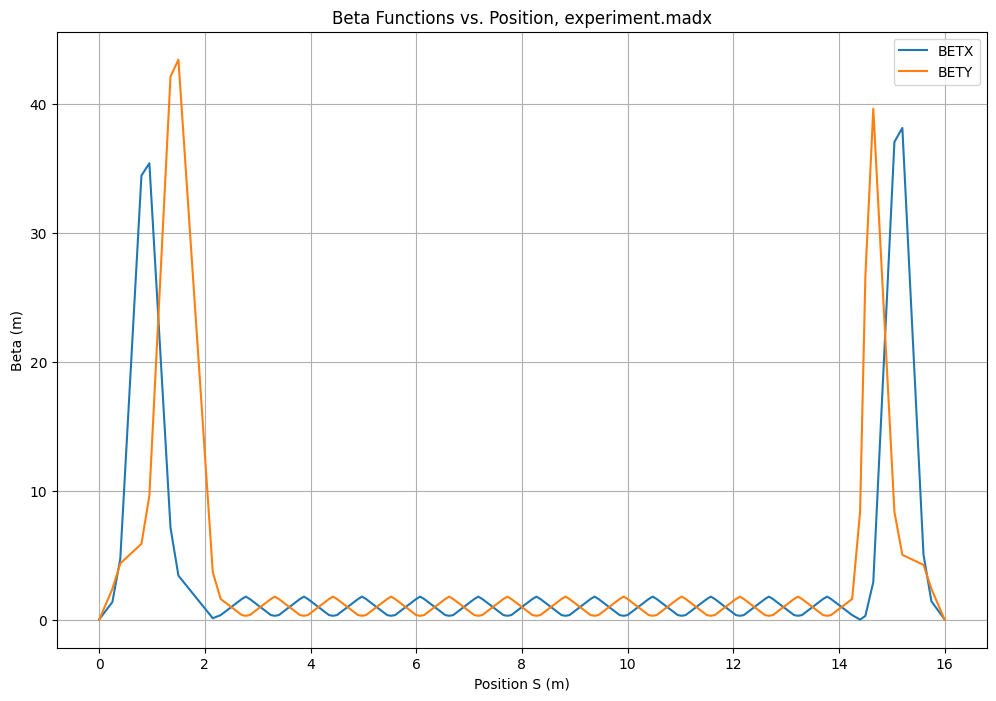

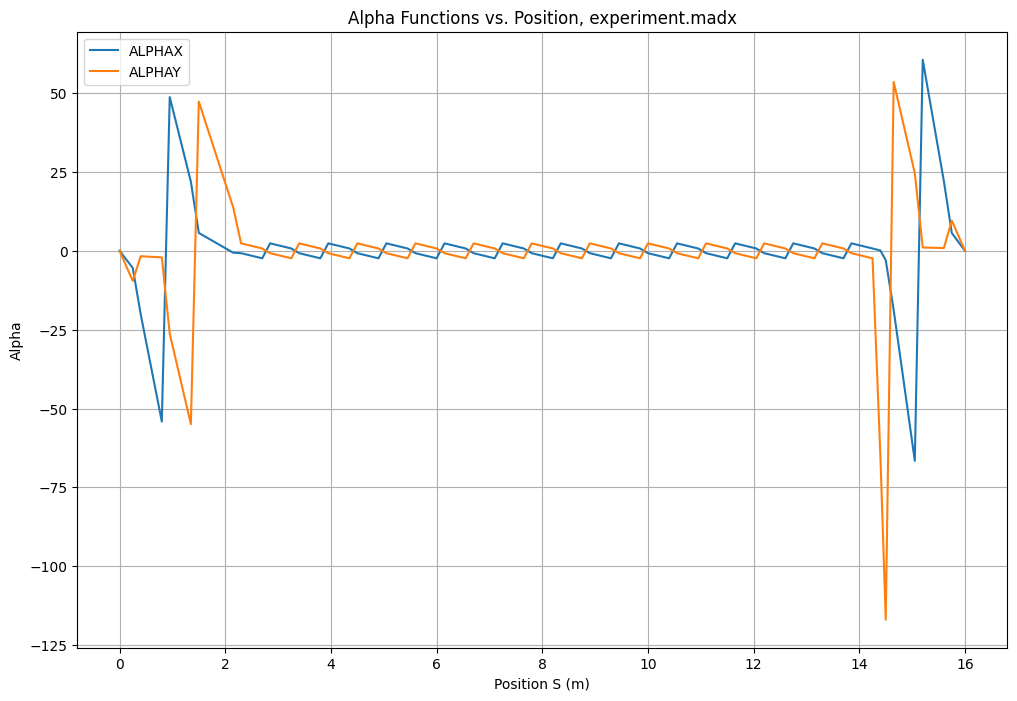

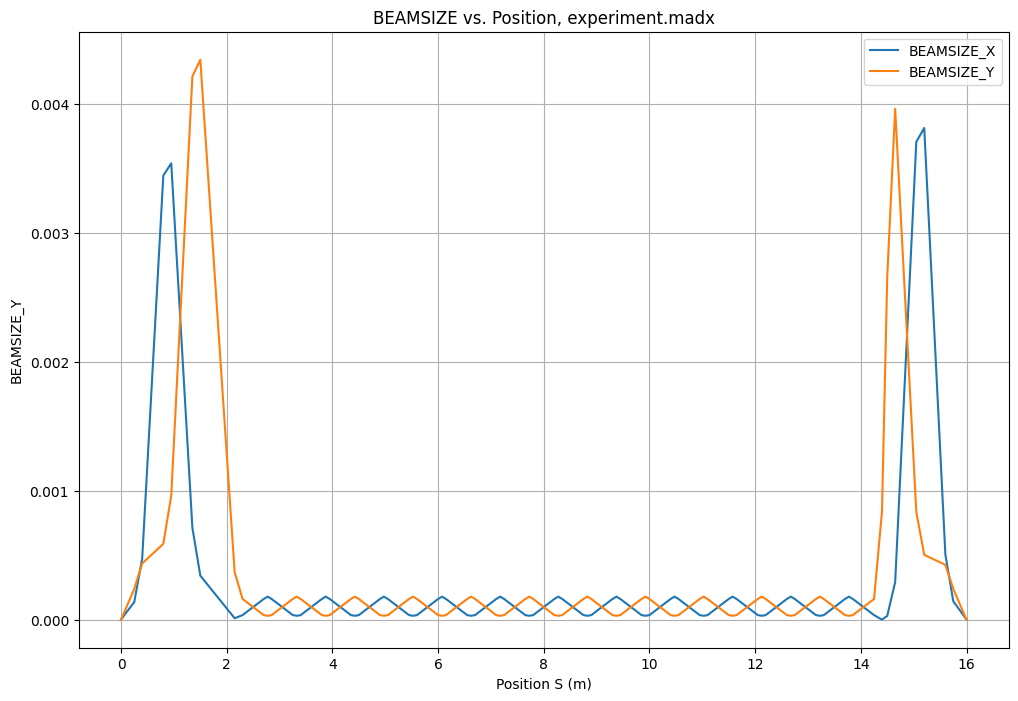

In [12]:
plot_twiss_parameters("experiment.madx", "whole.tfs")

In [13]:

ans = [19, -19]
energy = .13432 ## GeV
rest_energy = .10566 ## GeV
c = 0.3
for num in ans:
    a = ((energy ** 2) - (rest_energy ** 2)) ** 0.5
    pdividedbye = a / c
    print(pdividedbye * num * .075)

0.39393015519886254
-0.39393015519886254


In [14]:
starting_magnets = [-1.88495e+01, 1.89392e+01, -1.54793e+01, 2.28249e+01]
energy = .13432 ## GeV
rest_energy = .10566 ## GeV
c = 0.3
for num in starting_magnets:
    a = ((energy ** 2) - (rest_energy ** 2)) ** 0.5
    pdividedbye = a / c
    print(pdividedbye * num * .15)


-0.7816196274127325
0.7853391574044524
-0.6418697948810266
0.9464648841472123


In [15]:
ending_magnets = [0, -3.39354e+01, 2.16311e+01, -2.03412e+01]  ## k1 values
energy = .13432 ## GeV
rest_energy = .10566 ## GeV
c = 0.3
for num in ending_magnets:
    a = ((energy ** 2) - (rest_energy ** 2)) ** 0.5
    pdividedbye = a / c
    print(pdividedbye * num * .15)


0.0
-1.4071765672353136
0.8969623768549594
-0.8434749550453792


In [16]:

def plot_dispersion(nameofmadxfile, nameofoutputfile, remove=False):
    madx_path = '/Users/ryanmichaud/madx_project_2024/madx' 

    subprocess.run([madx_path, nameofmadxfile])




    S=[]
    BETX = []
    BETY = []
    ALPHAX = []
    ALPHAY = []
    disp_x = []
    disp_y = []
    disp_px = []
    disp_py = []
    with open(nameofoutputfile) as f:
        for line in f:
            if line.startswith('@') or line.startswith('*') or line.startswith('$'):
                continue
            values = line.split()
            S.append(float(values[2]))
            BETX.append(float(values[3]))
            BETY.append(float(values[6]))
            ALPHAX.append(float(values[4]))
            ALPHAY.append(float(values[7]))
            disp_x.append(float(values[15]))
            disp_y.append(float(values[17]))
            disp_px.append(float(values[16]))
            disp_py.append(float(values[18]))



    ## vertical


    # Plot BETX and BETY
    plt.figure(figsize=(12, 8))
    plt.plot(S, disp_x, label='dispersion x')
    plt.plot(S, disp_y, label='dispersion y')
    plt.xlabel('Position S (m)')
    plt.ylabel('Dispersion (m)')
    plt.title(f'Dispersion Functions vs. Position, {nameofmadxfile}')
    plt.legend()
    plt.grid(True)

    plt.show()
    if remove == True:
        os.remove(nameofmadxfile)
        os.remove(nameofoutputfile)

    plt.figure(figsize=(12, 8))
    plt.plot(S, disp_px, label='dispersion x')
    plt.plot(S, disp_py, label='dispersion y')
    plt.xlabel('Position S (m)')
    plt.ylabel('Momentum Dispersion (m)')
    plt.title(f'Momentum Dispersion Functions vs. Position, {nameofmadxfile}')
    plt.legend()
    plt.grid(True)
    plt.show()





  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2025.06.02 22:40:55      +
  ++++++++++++++++++++++++++++++++++++++++++++
BEAM, particle=POSMUON;

b_start: beta0, betx=0.0462, bety=0.0262, dx=0.01625, dy=-0.0002, dpx = -0.18, dpy = -0.02;



angle1=0.5;

angle2=0.5;

tilt1 = 0;

tilt2 = 0;



b1: rbend, l=1, angle:=angle1, tilt:=tilt1;

b2: rbend, l=1, angle:=angle2, tilt:=tilt2;



LINE: sequence, l=2.55;

    MF0: marker, at=0;



    b1, at = 0.55;

    b2, at = 2;

    MF1: marker, at=2.55;    

endsequence;



USE, sequence=line;

MATCH, sequence=line,beta0=b_start;

START MATCHING

number of sequences: 1
sequence name: line
number of beta0s: 1
BETA0 name: b_start


    vary, name=angle1, step=.00001;

    vary, name=angle2, step=.00001;

    !vary, name=s1, step=.00001;

    !vary, name=s2, step=.00001;

    constraint, r

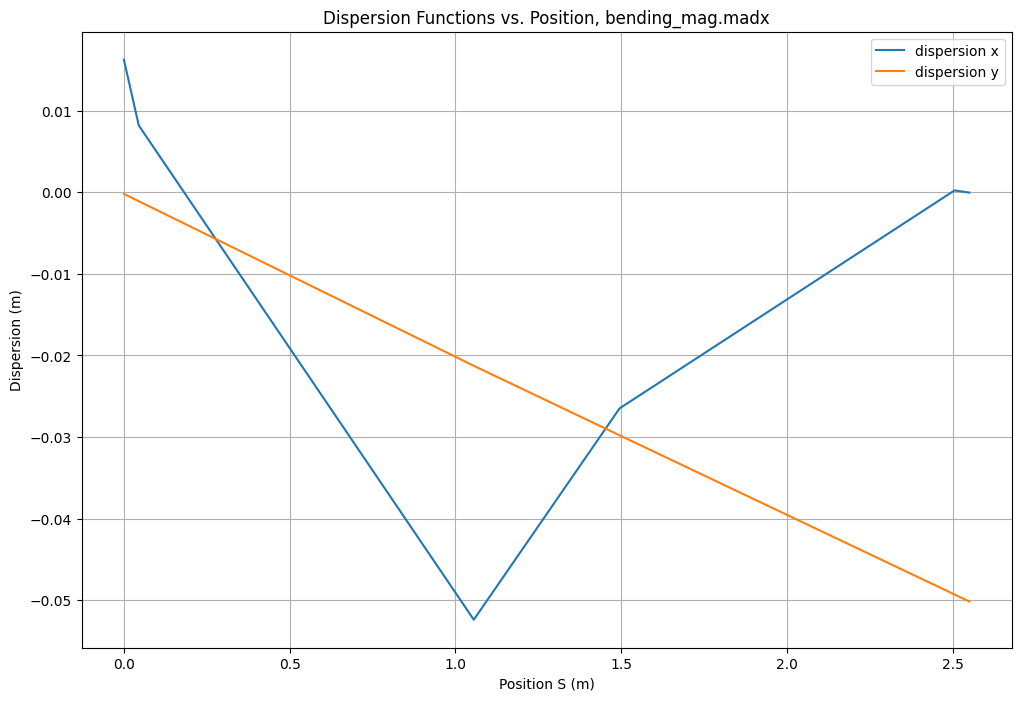

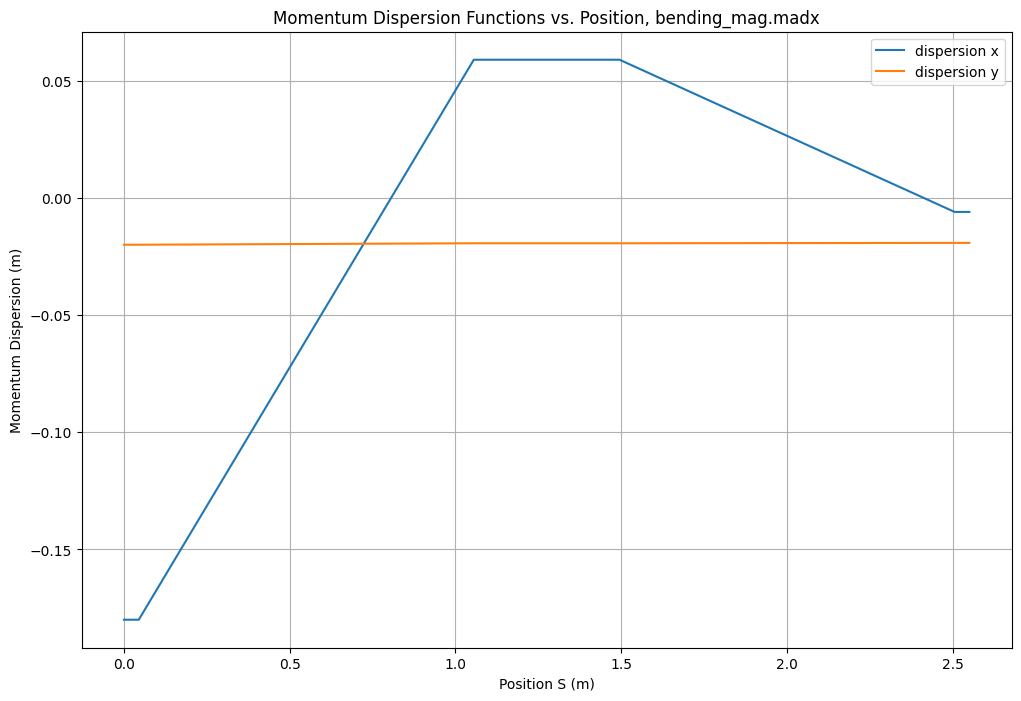

In [17]:
plot_dispersion("bending_mag.madx", "bending.tfs")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2025.06.02 22:40:55      +
  ++++++++++++++++++++++++++++++++++++++++++++
BEAM, particle=POSMUON;

b_start: beta0, betx=0.0462, bety=0.0262, dx=0.01625, dy=-0.0002, dpx = -0.18, dpy = -0.02;



angle1=0.5;

angle2=0.5;

tilt1 = 0;

tilt2 = 0;



b1: rbend, l=1, angle:=angle1, tilt:=tilt1;

b2: rbend, l=1, angle:=angle2, tilt:=tilt2;



LINE: sequence, l=2.55;

    MF0: marker, at=0;



    b1, at = 0.55;

    b2, at = 2;

    MF1: marker, at=2.55;    

endsequence;



USE, sequence=line;

MATCH, sequence=line,beta0=b_start;

START MATCHING

number of sequences: 1
sequence name: line
number of beta0s: 1
BETA0 name: b_start


    vary, name=angle1, step=.00001;

    vary, name=angle2, step=.00001;

    !vary, name=s1, step=.00001;

    !vary, name=s2, step=.00001;

    constraint, r

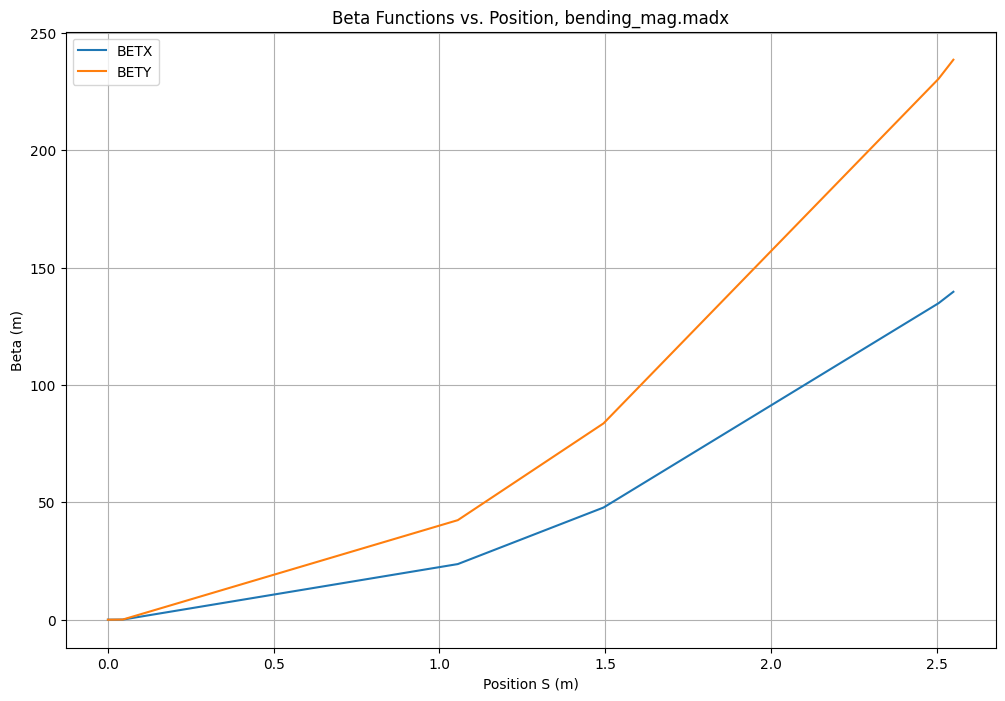

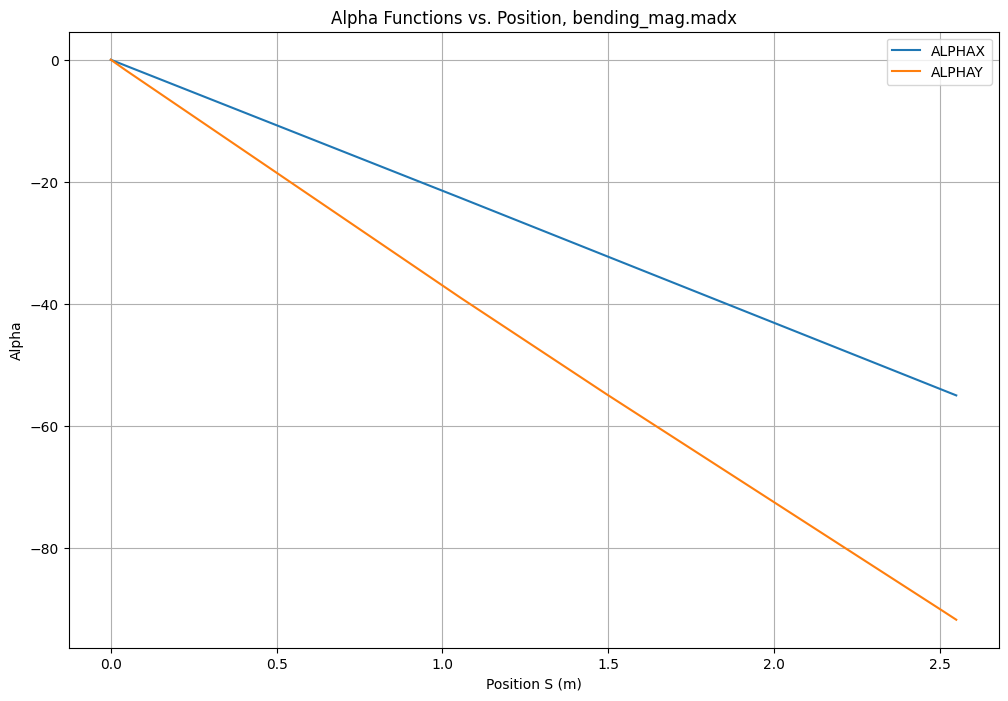

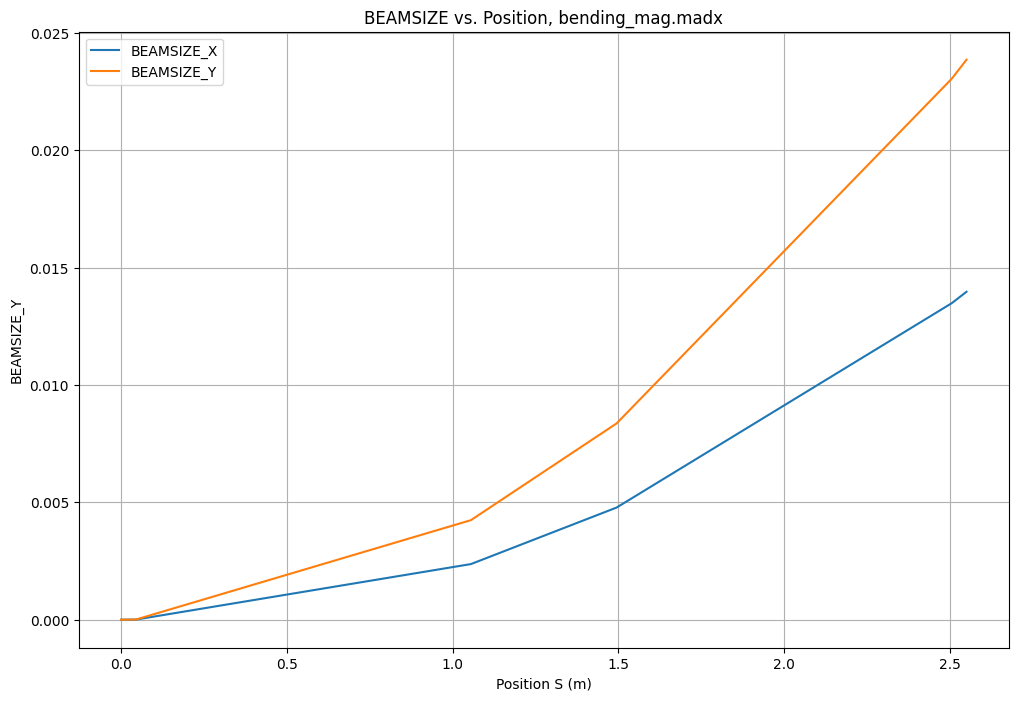

In [18]:
plot_twiss_parameters("bending_mag.madx", "bending.tfs")

In [19]:
def calc_bending_angle(angle, length):
    return (angle * 2 * 0.089) / length


In [20]:
angles = [2.36492e-01,  -6.45516e-02]
for i in range(len(angles)):
    print(calc_bending_angle(angles[i], 1))

0.042095576
-0.011490184799999999
